# An Exploratory Analysis of Linear Epitopes and Associated Antibody CDRs in IEDB

In this material, we are going to go through a brief exploratory analysis of the linear epitope data available in [the Immune Epitope Database (IEDB)][iedb].

This walkthrough has been used for writing the paper submitted to [XXIX Congresso de Iniciação Científica da Unicamp][xxix-pibic].

[iedb]: https://iedb.org
[xxix-pibic]: https://www.prp.unicamp.br/pibic/congressos/xxixcongresso

First, we are going to import some useful packages.

In [1]:
import sys
import os
from os import path
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Here, we are going to specify the directory where the raw data is available.

Two files are expected to be there:

1. `bcell_full.csv`. This file contains most data and metadata about the assays, where we extract host and publication dates, for instance.
2. `linear.csv`. This file has the sequence data for both epitope and CDRs.

You can download the latest version of these files following the instructions given in Methodology section of the paper.

In [2]:
%env DATA_DIR /path/to/iedb/data

env: DATA_DIR=/path/to/iedb/data


In [3]:
data_dir = os.getenv('DATA_DIR')

To make things a bit easier, let us create a auxiliary function for loading specific columns from the `bcell_full.csv` file.

We will do this mainly because it is not interesting to read all columns at once, since the file has ~1GB.

In [4]:
bcell_full_path = path.join(data_dir, 'bcell_full.csv')

def load(columns, unknown=True, reset=True, rename_index='count', nrows=None):
    '''
    Load the specified columns from bcell_full CSV file
    
    By default, it substitutes all NaN (empty) entries with the string "Unknown",
    and also creates a column 'count' with generated identifiers.
    '''
    if type(columns) is not list:
        columns = [columns]

    df = pd.read_csv(bcell_full_path, header=1, usecols=columns, nrows=nrows)

    if unknown:
        df = df.replace(np.NaN, 'Unknown')
    
    if reset:
        df = df.reset_index()
        if rename_index is not None:
            df = df.rename(columns={'index': str(rename_index)})

    return df

Now, we are ready for our exploration. 

## Epitope type over the years

We will start with checking how the data have been collected by the years. To do so, we will use the `Date` column, which specifies the year of the published papers, and `Object Type`, which says the type of the epitope.

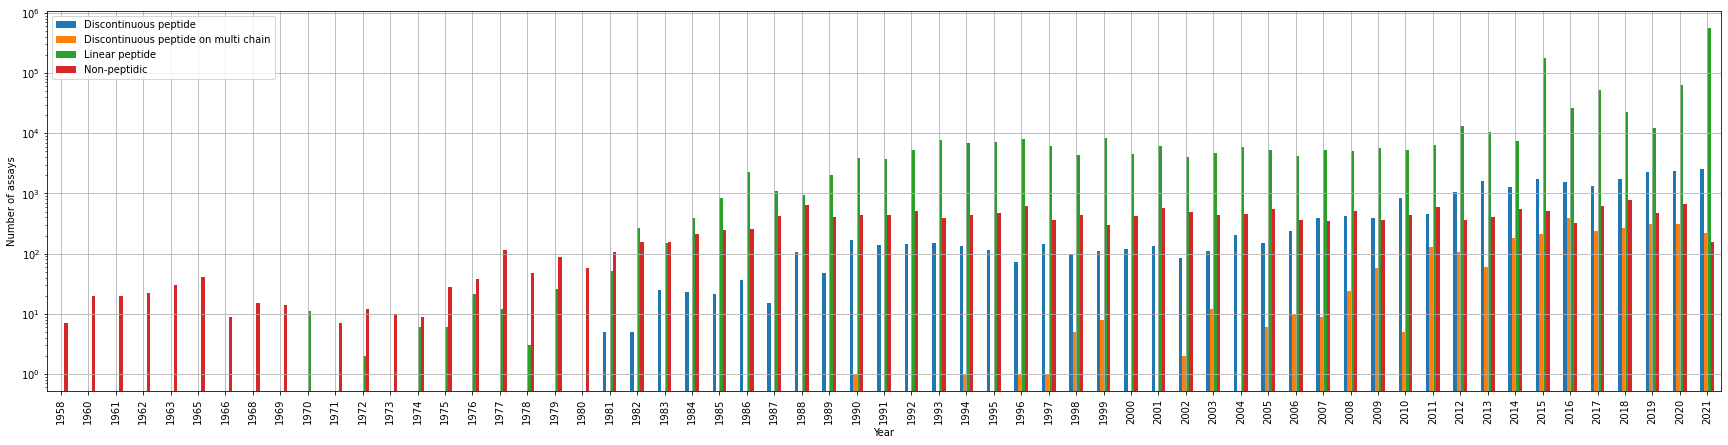

In [5]:
columns=['Date', 'Object Type']
df = load(columns=columns)

def plot_dates_objtype(df, cols):
    '''Plot the number of assays for each epitope type over the years'''

    df_dates = df.groupby(cols).count().unstack(level=1, fill_value=0)

    df_dates.columns = [v for _, v in df_dates.columns]

    return df_dates.plot.bar(grid=True, logy=True, figsize=(30, 7))

ax = plot_dates_objtype(df, columns)

ax.set_ylabel('Number of assays')
ax.set_xlabel('Year')

plt.show()

We can see that there are an significant increase in the number of assays available in IEDB.

Let's see how much of them there are in total.

In [6]:
print(f'Total number of assays: {len(df)}')

Total number of assays: 1125362


## Host distribution

Another information that is relevant to be checked out is the host where the data have been collected in the experiments. This information is available in the `Name` column.

In [7]:
col = 'Name'

df = load(columns=col, unknown=False)

df_host_orig = df.groupby([col]).count().reset_index()

df_host_orig.sort_values(by='Name')

,Name,count
0,Alouatta macconnelli,7
1,Anas (duck),96
2,Anas platyrhynchos (duck),404
3,Anser cygnoides domesticus,2
4,Anser sp. (goose),81
...,...,...
395,Trichosurus vulpecula (common brush-tailed pos...,61
396,Vicugna pacos,20
397,Vicugna pacos (alpaca),919
398,marmosets,10


As it can be noticed, there are several strains in IEDB. To have a simplified view of the host diversity in the dataset, we will collapse the strains from the top 10 most frequent species.

In [8]:
def group_rows_matching(df_host, pattern, merged_name):
    '''Group the rows matching the given pattern under the new entry named `merged_name`'''
    mask = df_host.Name.str.contains(pattern)

    if len(mask) == 0:
        print(f"{pattern} has zero matching entries, creating 0'd entry")

        species = pd.DataFrame([0], columns='count')
        df_host = df_host.append(pd.DataFrame([{'Name': merged_name, 'count': 0}]), ignore_index=True)
    
        return df_host

    species = df_host.loc[mask].copy()

    # display strains that will be merged
    display(species)

    df_host = df_host.drop(species.index)\
                .append(pd.DataFrame([{'Name': merged_name, 'count': species['count'].sum()}]), ignore_index=True)

    return df_host

# Pattern and respective merged name that will be applied.
# These are the most frequent species, as we will see
host_names = {
    r'Homo sapiens': 'Homo sapiens (human)',
    r'[Mm]us musculus': 'Mus musculus (mouse)',
    r'Oryctolagus cuniculus': 'Oryctolagus cuniculus (rabbit)',
    r'Macaca mulatta': 'Macaca mulatta (rhesus macaque)',
    r'Gallus gallus': 'Gallus gallus (chicken)',
    r'Equus caballus': 'Equus caballus (domestic horse)',
    r'Aotus': 'Aotus (night monkey)',
    r'Sus scrofa': 'Sus scrofa (pig)',
    r'Ovis aries': 'Ovis aries (domestic sheep)',
    r'Bos taurus': 'Bos taurus (bovine)',
}

df_host = df_host_orig

for name, merged_name in host_names.items():
    df_host = group_rows_matching(df_host, name, merged_name=merged_name)

,Name,count
66,Homo sapiens,556277
67,Homo sapiens (human),409068
68,Homo sapiens Australian Aboriginal,90
69,Homo sapiens Black,15
70,Homo sapiens Caucasian,410


,Name,count
87,Mus musculus,37
88,Mus musculus (C57BL/6 X A/J),84
89,Mus musculus (CBA/J X C57BL/6J) human IgH Tg h...,25
90,Mus musculus (mouse),13897
91,Mus musculus 129,30
...,...,...
295,Mus musculus hTNF Tg,19
296,Mus musculus human duffy Fyb protein Tg,1
297,Mus musculus shiverer (MBP null),1
298,Mus musculus viable motheaten,6


,Name,count
98,Oryctolagus cuniculus,62
99,Oryctolagus cuniculus (rabbit),19291
100,Oryctolagus cuniculus Belgian White,3
101,Oryctolagus cuniculus Blanc de Bouscat,83
102,Oryctolagus cuniculus California Satin,1
103,Oryctolagus cuniculus California x New Zealand...,2
104,Oryctolagus cuniculus Californian,6
105,Oryctolagus cuniculus Chinchilla,291
106,Oryctolagus cuniculus Chinchilla Bastard,43
107,Oryctolagus cuniculus Danish White,5


,Name,count
72,Macaca mulatta,1
73,Macaca mulatta (rhesus macaque),6064


,Name,count
56,Gallus gallus (chicken),1248
57,Gallus gallus Brown leghorn Hisex,10
58,Gallus gallus Cobb 500,9
59,Gallus gallus H.B15,12
60,Gallus gallus Leghorn,242
61,Gallus gallus P2a,3
62,Gallus gallus SynVH,10
63,Gallus gallus White Leghorn,903


,Name,count
51,Equus caballus (domestic horse),2156
52,Equus caballus Arabian,3


,Name,count
5,Aotus (night monkey),2089
6,Aotus griseimembra,5
7,Aotus lemurinus (lemurine night monkey),43
8,Aotus nancymaae (Ma's night monkey),468
9,Aotus trivirgatus (night monkey),13


,Name,count
131,Sus scrofa (pig),2009
132,Sus scrofa Camborough 22,81
133,Sus scrofa Duroc X Yorkshire X Hampshire,38
134,Sus scrofa German Landrace,4
135,Sus scrofa Landrace X Large White,426
136,Sus scrofa Miniature Minnesota,2
137,Sus scrofa NIH miniature pig,5
138,Sus scrofa Yorkshire,47
139,"Sus scrofa alpha1,3GALT null",5
140,Sus scrofa domesticus (domestic pig),3


,Name,count
81,Ovis aries (domestic sheep),1747
82,Ovis aries Finnish Landrace,7
83,Ovis aries Merino,502
84,Ovis aries Merino X Border Leiscester,16
85,Ovis aries Romanov,4


,Name,count
7,Bos taurus,5
8,Bos taurus (bovine),1713
9,Bos taurus Friesian,29
10,Bos taurus Hereford,32
11,Bos taurus Holstein,248
12,Bos taurus Holstein X Charolais,1
13,Bos taurus Holstein-Friesian,515
14,Bos taurus Japanese Black,157
15,Bos taurus Jersey,1
16,Bos taurus Santa Gertrudis,3


In [9]:
df_host.sort_values('count', inplace=True, ascending=False)

df_host.head(20)

,Name,count
119,Homo sapiens (human),965860
120,Mus musculus (mouse),89089
121,Oryctolagus cuniculus (rabbit),35243
122,Macaca mulatta (rhesus macaque),6065
128,Bos taurus (bovine),2716
126,Sus scrofa (pig),2620
125,Aotus (night monkey),2618
123,Gallus gallus (chicken),2437
127,Ovis aries (domestic sheep),2276
124,Equus caballus (domestic horse),2159


We will now plotting this as a bar chart.

<AxesSubplot:xlabel='Host species', ylabel='Number of assays'>

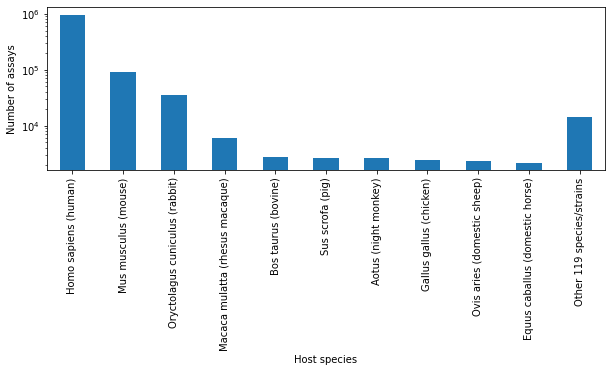

In [10]:
df_host.sort_values('count', inplace=True, ascending=False)

df_head = df_host.head(10)
df_tail = df_host.loc[~df_host.index.isin(df_head.index)]

tail_sum = df_tail.set_index(col).sum().values[0]

df_tail = pd.DataFrame([(f'Other {len(df_tail)} species/strains', tail_sum)], columns=df_host.columns)

df_host_plot = pd.concat([df_head, df_tail]).rename(columns={'count': 'count'})

host_axis = df_host_plot.plot.bar(x=col, figsize=(10,3), logy=True, legend=False)
host_axis.set_xlabel('Host species')
host_axis.set_ylabel('Number of assays')

host_axis

### Epitope type

As we have seen before, there is four types of epitope types:

- Discontinuous peptide
- Discontinuous peptide on multi-chain
- Linear (continuous) peptide
- Non-peptidic

Let's plot an overview of these types.

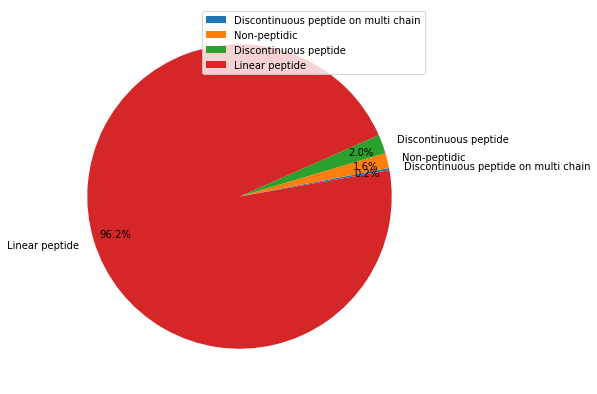

In [11]:
df_type = load(columns='Object Type')

df_type = df_type.groupby('Object Type').count()

df_type.sort_values(by='count', inplace=True)

ax = df_type.plot.pie(y='count', figsize=(7,7), autopct='%1.1f%%', pctdistance=.85, startangle=10)

ax.set_xlabel(None)
ax.set_ylabel(None)

plt.show()

## Linear epitopes

We have seen so far properties of all data from B-cell assays.

In order to analize linear epitopes and their CDRs as well, we will need to load `linear.csv` file as well.

This is because CDR information is not available in `bcell_full.csv`.

Moreover, as an attempt to make the code a bit cleaner, we will now use some auxiliary classes from our [utilitary library](./util).
If anything looks fuzzy, feel free to analyze its code as we go on.

In [12]:
from util import get_dataset
from argparse import Namespace

config = Namespace(**{
    'name': 'IEDBDataset',
    'params': {
        'dir': data_dir,
        'file': 'linear.csv',
    },
})

dataset = get_dataset(config)

print(dataset)

IEDBDataset (from: linear.csv, rows: 485)


Here we see that the dataset, after all cleaning, have 485 rows. The cleaning steps applied to it are the ones described in the Methodology section of the paper.

It cleaned data is accessible as pandas `DataFrame` in the `data` field, and the data directly loaded from the file is available in the `raw` field.

In [13]:
dataset.data

,cdrl3,cdrh3
epitope,,
IEESDDRRYDLVGP,ALWYSNHLV,ARMWYYGTYYFDY
KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
RMKQLEPKVEELLPKNYHLENEVARLKKLVGER,ALWYSNHWV,VTGLFDY
YHLENEVARLKK,ALWYSNHWV,VTGLFDY
WNWFDITNW,QQYGQSLST,AREGTTGWGWLGKPIGAFAH
...,...,...
RRTTHYGNSYL,QNDFSYPLT,AKEIFY
ATRRTTHYGNSYLEG,QNDFSYPLT,AKEIFY
SHRANETIYNTTLKYGD,QQRSMWPPVT,ARDGKCGGGRCYSGLLDY


In [14]:
dataset.raw

,Group Receptor ID,Receptor ID,Reference ID,Epitope ID,Description,Antigen,Organism,Response Type,Assay IDs,Reference Name,...,Chain 2 CDR1 Start Curated,Chain 2 CDR1 End Curated,Chain 2 CDR1 Start Calculated,Chain 2 CDR1 End Calculated,Chain 2 CDR2 Curated,Chain 2 CDR2 Calculated,Chain 2 CDR2 Start Curated,Chain 2 CDR2 End Curated,Chain 2 CDR2 Start Calculated,Chain 2 CDR2 End Calculated
0,6,6,322,116192,"3,4-dihydroxy-9,10-dioxo-9,10-dihydroanthracen...",NaN,NaN,B cell,311,SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0
1,6,6,322,109326,IEESDDRRYDLVGP,NaN,NaN,B cell,"1649125, 2014391",SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0
2,6,6,322,116184,furazolidone,NaN,NaN,B cell,2014390,SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0
3,6,6,322,112741,"2,4-dinitrophenyl group",NaN,Mus musculus (mouse),B cell,"310, 2014388",SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0
4,6,6,322,116192,"3,4-dihydroxy-9,10-dioxo-9,10-dihydroanthracen...",NaN,NaN,B cell,2014389,SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,181208,201242,1038104,1337863,SNNPDWDF,large S protein,HBV genotype C,B cell,"12627151, 12627152, 12627199, 12627200, 12627201",BP-L16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1815,181208,201242,1038104,1336845,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANQV,large S protein,HBV genotype C,B cell,12627144,BP-L16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816,181209,201243,1038104,1337520,PNPLGFFPD,large S protein,HBV genotype C,B cell,"12627153, 12627154, 12627170, 12627178, 126271...",BP-L34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1817,181210,201244,1038104,1336668,FGANSNNPDW,large S protein,HBV genotype C,B cell,"12627155, 12627156, 12627205, 12627206, 12627207",BP-L37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As it can be seen, in `linear.csv` we have assays and epitopes IDs, whereas in B-cell table there are only `Assay IRI` and `Epitope IRI`. However, we can use the final number from the IRI to extract their ID. This way, we will be able to join information from both tables.

Specifically the assay identification is not normalized in the `linear.csv` table, as the column is multivalued. Therefore, to join the tables, we would need to replicate the rows, each with a different assay ID. However, in some analysis, it is possible to create a list of all unintended ids and check whether any of them occurs in the `Assay IDs` for each entry. 

That's what we will do next to check whether any of the assays listed in the `linear.csv` file is mistakenly considered _negative_.

In [15]:
linear_csv = dataset.raw.copy()

outcome = load(columns=['Assay IRI', 'Qualitative Measure'])

neg_outcome = outcome[outcome['Qualitative Measure'] == 'Negative']

neg_outcome_ids = list(neg_outcome['Assay IRI'].map(lambda x: int(x.split('/')[-1])).unique())

def filter_negative(entry):
    assay_ids = [int(v) for v in entry['Assay IDs'].split(',')]
    
    return all([assay in neg_outcome_ids for assay in assay_ids])

linear_csv[linear_csv.apply(filter_negative, axis='columns')]

,Group Receptor ID,Receptor ID,Reference ID,Epitope ID,Description,Antigen,Organism,Response Type,Assay IDs,Reference Name,...,Chain 2 CDR1 Start Curated,Chain 2 CDR1 End Curated,Chain 2 CDR1 Start Calculated,Chain 2 CDR1 End Calculated,Chain 2 CDR2 Curated,Chain 2 CDR2 Calculated,Chain 2 CDR2 Start Curated,Chain 2 CDR2 End Curated,Chain 2 CDR2 Start Calculated,Chain 2 CDR2 End Calculated
5,6,6,1005421,116191,"9,10-anthraquinone",NaN,NaN,B cell,1678661,SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0
8,6,6,1005421,116190,anthrarufin,NaN,NaN,B cell,1678662,SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0
9,6,6,1005421,116188,anthrone,NaN,NaN,B cell,1678660,SPE7,...,NaN,NaN,26.0,34.0,NaN,GTN,NaN,NaN,52.0,54.0


This implies that no entry in the data of peptidic epitopes we downloaded from the IEDB interface is classified as negative in all assays, according to `bcell_full`. 

These three entries we just found are removed from our analysis when a filtering process is done on both linear epitopes and discontinuous epitopes. 

### Linear epitope hosts

Now, let see how is the distribution of host species of the subset of linear epitope we selected previously.

In [16]:
df_host_id = load(columns=['Assay IRI', 'Name'], unknown=False)

df_host_id['id'] = df_host_id['Assay IRI'].apply(lambda iri: int(iri.split('/')[-1]))

df_host_id

,count,Assay IRI,Name,id
0,0,http://www.iedb.org/assay/5,Mus musculus (mouse),5
1,1,http://www.iedb.org/assay/14,Mus musculus BALB/c,14
2,2,http://www.iedb.org/assay/31,Mus musculus BALB/c,31
3,3,http://www.iedb.org/assay/32,Mus musculus BALB/c,32
4,4,http://www.iedb.org/assay/33,Mus musculus (mouse),33
...,...,...,...,...
1125357,1125357,http://www.iedb.org/assay/15911411,Homo sapiens (human),15911411
1125358,1125358,http://www.iedb.org/assay/15911412,Homo sapiens (human),15911412
1125359,1125359,http://www.iedb.org/assay/15911413,Homo sapiens (human),15911413
1125360,1125360,http://www.iedb.org/assay/15913436,Homo sapiens (human),15913436


In [17]:
from util import Normalizer

df_receptors = Normalizer(linear_csv) \
            .columns({
                'Assay IDs': 'ids',
                'Description': 'epitope',
                'Chain 1 Type': 'chain1_type',
                'Chain 2 Type': 'chain2_type',
                'Chain 1 CDR3 Calculated': 'cdrh3',
                'Chain 2 CDR3 Calculated': 'cdrl3',
            }) \
            .trim(['chain1_type', 'chain2_type']) \
            .chains(chain1_col='chain1_type', chain1_type='heavy', chain2_col='chain2_type', chain2_type='light') \
            .keep(['ids', 'epitope', 'cdrl3', 'cdrh3']) \
            .trim(['epitope', 'cdrl3', 'cdrh3']) \
            .filter(column='epitope', pattern=r'^[A-Z]+$') \
            .drop_nan().finish()

df_receptors

,ids,epitope,cdrl3,cdrh3
1,"1649125, 2014391",IEESDDRRYDLVGP,ALWYSNHLV,ARMWYYGTYYFDY
25,"1376701, 1376702, 1376705, 1376706, 1376707",KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
26,2213,KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
27,1376700,KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
28,1377940,RMKQLEPKVEELLPKNYHLENEVARLKKLVGER,ALWYSNHWV,VTGLFDY
...,...,...,...,...
1254,8142247,ATRRTTHYGNSYLEG,QNDFSYPLT,AKEIFY
1259,"12394501, 12394508",NTGWLAGLFYQHK,QAWDSSALV,ARGPLSRGYYDY
1316,"12391064, 12391065, 12391066, 12391067, 123910...",SHRANETIYNTTLKYGD,QQRSMWPPVT,ARDGKCGGGRCYSGLLDY
1317,"12391064, 12391066",SHRANETIYNTTLKYGD,QQRSSWPPIT,AREGLSREKNGYSGLIDY


As mentioned before, we will now create a list of IDs that contains all entries we are interested about, by using the `ids` column in the previous `DataFrame`.

In [18]:
ids = []
for cur in df_receptors['ids']:
    ids += [int(x) for x in cur.split(',')]

ids = list(set(ids))

len(ids)

1581

Now, let us count each species as we have done before.

In [19]:
linear_host = df_host_id.loc[df_host_id['id'].isin(ids), 'Name']

linear_host = linear_host.reset_index().groupby('Name').count() \
    .rename(columns={'index': 'count'}) \
    .reset_index()

assert linear_host['count'].sum() == len(ids)

linear_host

,Name,count
0,Bos taurus (bovine),4
1,Gallus gallus Leghorn,4
2,Homo sapiens (human),648
3,Macaca mulatta (rhesus macaque),1
4,Mus musculus (mouse),167
5,Mus musculus 129 GIX+,5
6,Mus musculus A.SW,2
7,Mus musculus A/J,9
8,Mus musculus BALB/c,552
9,Mus musculus BALB/c X C3H,1


Also, we merge the very same species as before.

In [20]:
linear_host_merged = linear_host

for name, merged_name in host_names.items():
    linear_host_merged = group_rows_matching(linear_host_merged, name, merged_name=merged_name)

linear_host_merged

,Name,count
2,Homo sapiens (human),648


,Name,count
3,Mus musculus (mouse),167
4,Mus musculus 129 GIX+,5
5,Mus musculus A.SW,2
6,Mus musculus A/J,9
7,Mus musculus BALB/c,552
8,Mus musculus BALB/c X C3H,1
9,Mus musculus BDF1,2
10,Mus musculus C3H,7
11,Mus musculus C57BL/6,12
12,Mus musculus CBA,19


,Name,count
3,Oryctolagus cuniculus (rabbit),9
4,Oryctolagus cuniculus New Zealand White,35


,Name,count
2,Macaca mulatta (rhesus macaque),1


,Name,count
1,Gallus gallus Leghorn,4


,Name,count


,Name,count


,Name,count
4,Sus scrofa (pig),12


,Name,count


,Name,count
0,Bos taurus (bovine),4


,Name,count
0,Rattus norvegicus (brown rat),19
1,Rattus norvegicus DA,1
2,Rattus norvegicus Sprague-Dawley,6
3,Homo sapiens (human),648
4,Mus musculus (mouse),842
5,Oryctolagus cuniculus (rabbit),44
6,Macaca mulatta (rhesus macaque),1
7,Gallus gallus (chicken),4
8,Equus caballus (domestic horse),0
9,Aotus (night monkey),0


In [21]:
linear_host_merged.sort_values(by='count', ascending=False, inplace=True)

linear_host_merged

,Name,count
4,Mus musculus (mouse),842
3,Homo sapiens (human),648
5,Oryctolagus cuniculus (rabbit),44
0,Rattus norvegicus (brown rat),19
10,Sus scrofa (pig),12
2,Rattus norvegicus Sprague-Dawley,6
7,Gallus gallus (chicken),4
12,Bos taurus (bovine),4
1,Rattus norvegicus DA,1
6,Macaca mulatta (rhesus macaque),1


Now, we can plot it.

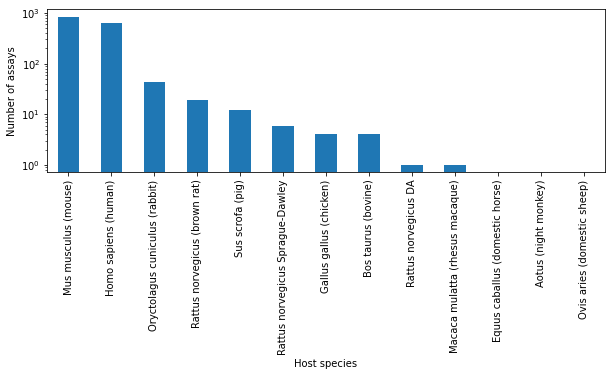

In [22]:
ax = linear_host_merged.plot.bar(x='Name', y='count', legend=False, logy=True, figsize=(10,3))

ax.set_ylabel('Number of assays')
ax.set_xlabel('Host species')

plt.show()

## Non-peptidic epitopes

Non-peptidic epitopes are molecules such as carbohydrates that also have been neutralized by the immune system.

From our query to IEDB, there should be no non-peptidic entries in `linear.csv`. Let us see if that is really the case.

In [23]:
linear = Normalizer(linear_csv) \
        .columns({
            'Epitope ID': 'id',
            'Description': 'epitope',
        }).finish()

display(linear)

types = load(columns=['Epitope IRI', 'Object Type']).drop('count', axis='columns')

types

,id,epitope
0,116192,"3,4-dihydroxy-9,10-dioxo-9,10-dihydroanthracen..."
1,109326,IEESDDRRYDLVGP
2,116184,furazolidone
3,112741,"2,4-dinitrophenyl group"
4,116192,"3,4-dihydroxy-9,10-dioxo-9,10-dihydroanthracen..."
...,...,...
1814,1337863,SNNPDWDF
1815,1336845,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANQV
1816,1337520,PNPLGFFPD
1817,1336668,FGANSNNPDW


,Epitope IRI,Object Type
0,http://www.iedb.org/epitope/77408,Discontinuous peptide
1,http://www.iedb.org/epitope/77413,Discontinuous peptide
2,http://www.iedb.org/epitope/77450,Discontinuous peptide
3,http://www.iedb.org/epitope/77533,Discontinuous peptide
4,http://www.iedb.org/epitope/190616,Discontinuous peptide
...,...,...
1125357,http://www.iedb.org/epitope/1539325,Discontinuous peptide
1125358,http://www.iedb.org/epitope/1539325,Discontinuous peptide
1125359,http://www.iedb.org/epitope/1539325,Discontinuous peptide
1125360,http://www.iedb.org/epitope/1539326,Discontinuous peptide


We have loaded the needed information `Epitope IRI` and the `Object type`.

But we still need to transform the IRI to ID, in order to be able to join both tables.

In [24]:
types['id'] = types['Epitope IRI'].apply(lambda iri: int(iri.split('/')[-1]))

linear_types = types.join(linear.set_index('id'), on='id', how='inner')

linear_types.sort_values(by='epitope')

,Epitope IRI,Object Type,id,epitope
140569,http://www.iedb.org/epitope/164065,Non-peptidic,164065,(6S)-6-C-methyl-D-mannopyranose
140569,http://www.iedb.org/epitope/164065,Non-peptidic,164065,(6S)-6-C-methyl-D-mannopyranose
140572,http://www.iedb.org/epitope/164065,Non-peptidic,164065,(6S)-6-C-methyl-D-mannopyranose
140572,http://www.iedb.org/epitope/164065,Non-peptidic,164065,(6S)-6-C-methyl-D-mannopyranose
363283,http://www.iedb.org/epitope/509200,Non-peptidic,509200,"1,2-dihexanoyl-sn-glycero-3-phosphate"
...,...,...,...,...
165235,http://www.iedb.org/epitope/115009,Non-peptidic,115009,phosphocholine
159918,http://www.iedb.org/epitope/115009,Non-peptidic,115009,phosphocholine
156393,http://www.iedb.org/epitope/115009,Non-peptidic,115009,phosphocholine
116197,http://www.iedb.org/epitope/115009,Non-peptidic,115009,phosphocholine


As we see here, there are several entries for the same epitope.

To remove this factor in our proportion plot, we will keep only those containing different epitopes.

In [25]:
linear_types = linear_types.drop_duplicates(subset='epitope')

linear_types

,Epitope IRI,Object Type,id,epitope
20,http://www.iedb.org/epitope/112741,Non-peptidic,112741,"2,4-dinitrophenyl group"
21,http://www.iedb.org/epitope/116192,Non-peptidic,116192,"3,4-dihydroxy-9,10-dioxo-9,10-dihydroanthracen..."
22,http://www.iedb.org/epitope/116184,Non-peptidic,116184,furazolidone
51,http://www.iedb.org/epitope/7491,Linear peptide,7491,DAEFRHDSGYEVHHQK
724,http://www.iedb.org/epitope/59318,Linear peptide,59318,SLLTEVETPIRNEWGCRCNDSSD
...,...,...,...,...
555463,http://www.iedb.org/epitope/1337862,Linear peptide,1337862,SNNPDWD
555465,http://www.iedb.org/epitope/1337519,Linear peptide,1337519,PNPLGF
555467,http://www.iedb.org/epitope/1337420,Linear peptide,1337420,NPNKDHW
555469,http://www.iedb.org/epitope/1337580,Linear peptide,1337580,QLDPAFGANSNNPDWDFN


This leaves us with about a thousand entries. 

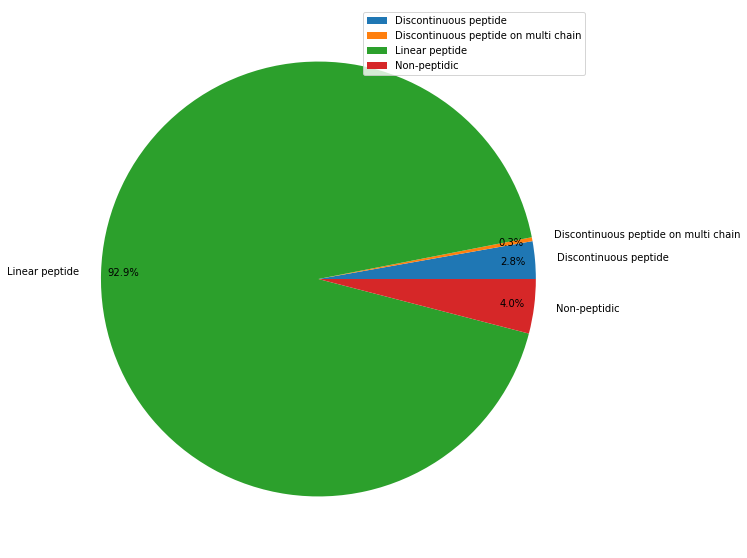

In [26]:
ax = linear_types.groupby('Object Type').count().plot.pie(y='id', figsize=(10,10), autopct='%1.1f%%', pctdistance=.9, labeldistance=1.1)

ax.set_ylabel(None)
ax.set_xlabel(None)

plt.show()

As suspected from a brief overview of the table, there are non-peptidic entries included, and they correspond to about 4% of all distinct epitopes.

Therefore, it is needed to filter even further the retrieved data.

In order to have only linear epitopes, we will keep only entries whose epitope is a string containing only uppercase letters.

In [27]:
receptors_dup = Normalizer(linear_csv) \
            .columns({
                'Epitope ID': 'id',
                'Description': 'epitope',
                'Chain 1 Type': 'chain1_type',
                'Chain 2 Type': 'chain2_type',
                'Chain 1 CDR3 Calculated': 'cdrh3',
                'Chain 2 CDR3 Calculated': 'cdrl3',
            }) \
            .trim(['chain1_type', 'chain2_type']) \
            .chains(chain1_col='chain1_type', chain1_type='heavy', chain2_col='chain2_type', chain2_type='light') \
            .keep(['id', 'epitope', 'cdrl3', 'cdrh3']) \
            .trim(['epitope', 'cdrl3', 'cdrh3']) \
            .filter(column='epitope', pattern=r'^[A-Z]+$') \
            .drop_nan().finish()

display(receptors_dup)

receptors = receptors_dup.drop_duplicates(subset=['epitope','cdrl3', 'cdrh3'])

receptors

,id,epitope,cdrl3,cdrh3
1,109326,IEESDDRRYDLVGP,ALWYSNHLV,ARMWYYGTYYFDY
25,32990,KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
26,32990,KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
27,32990,KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
28,54911,RMKQLEPKVEELLPKNYHLENEVARLKKLVGER,ALWYSNHWV,VTGLFDY
...,...,...,...,...
1254,1074861,ATRRTTHYGNSYLEG,QNDFSYPLT,AKEIFY
1259,167351,NTGWLAGLFYQHK,QAWDSSALV,ARGPLSRGYYDY
1316,1330586,SHRANETIYNTTLKYGD,QQRSMWPPVT,ARDGKCGGGRCYSGLLDY
1317,1330586,SHRANETIYNTTLKYGD,QQRSSWPPIT,AREGLSREKNGYSGLIDY


,id,epitope,cdrl3,cdrh3
1,109326,IEESDDRRYDLVGP,ALWYSNHLV,ARMWYYGTYYFDY
25,32990,KQHTVTTTTKGE,WQGSHFPQT,TRGTDY
28,54911,RMKQLEPKVEELLPKNYHLENEVARLKKLVGER,ALWYSNHWV,VTGLFDY
29,74117,YHLENEVARLKK,ALWYSNHWV,VTGLFDY
30,146625,WNWFDITNW,QQYGQSLST,AREGTTGWGWLGKPIGAFAH
...,...,...,...,...
1253,1075040,RRTTHYGNSYL,QNDFSYPLT,AKEIFY
1254,1074861,ATRRTTHYGNSYLEG,QNDFSYPLT,AKEIFY
1316,1330586,SHRANETIYNTTLKYGD,QQRSMWPPVT,ARDGKCGGGRCYSGLLDY
1317,1330586,SHRANETIYNTTLKYGD,QQRSSWPPIT,AREGLSREKNGYSGLIDY


By doing so, we end up with only 485 entries of the original 1125362 assays. It is important to note that multiple assays might have led to the 485 entries, nonetheless they are still duplicated and, in some sense, not conveying new sequences.

## Amino acid representativeness

It makes sense that some amino acids are more frequent in proteins than others. In fact, we can see that by the large protein data banks, such as [UniProt][uniprot].

In their summary statistics, we find that leucine (L) is the most frequent, followed by alanine (A), while tryptophan (W) is almost 9 times less found than leucine, being the least frequent.

It is also known that CDR3 have amino acids distribution that differs from general protein. Let us confirm that the same properties can be seen in our filtered data and in epitope types.

For doing so, we will use Swiss-Prot subset from UniProt, consisting in manually curated data. Besides, TrEMBL (a non-curated subset) statatics are also available here in case you are willing to check out the difference.

[uniprot]: https://www.uniprot.org/statistics/.

In [28]:
databases = {
    # UniProtKB/Swiss-Prot protein knowledgebase release 2021_03 statistics
    #
    # Release 2021_03 of 02-Jun-21 of UniProtKB/Swiss-Prot contains 565254 sequence entries,
    # comprising 203850821 amino acids abstracted from 279685 references. 
    #
    # https://web.expasy.org/docs/relnotes/relstat.html
    'Swiss-Prot': {
        'A': 0.0825,
        'Q': 0.0393,
        'L': 0.0965,
        'S': 0.0664,
        'R': 0.0553,
        'E': 0.0672,
        'K': 0.0580,
        'T': 0.0535,
        'N': 0.0406,
        'G': 0.0707,
        'M': 0.0241,
        'W': 0.0110,
        'D': 0.0546,
        'H': 0.0227,
        'F': 0.0386,
        'Y': 0.0292,
        'C': 0.0138,
        'I': 0.0591,
        'P': 0.0473,
        'V': 0.0686,
    },

    # UniProtKB/TrEMBL PROTEIN DATABASE RELEASE 2021_03 STATISTICS
    #
    # Release 2021_03 of 02-Jun-2021 of UniProtKB/TrEMBL contains 219174961 sequence entries,
    # comprising 75271144009 amino acids.
    #
    # https://www.ebi.ac.uk/uniprot/TrEMBLstats
    'TrEMBL': {
        'A': 0.0920,
        'Q': 0.0377,
        'L': 0.0990,
        'S': 0.0668,
        'R': 0.0583,
        'E': 0.0620,
        'K': 0.0489,
        'T': 0.0554,
        'N': 0.0377,
        'G': 0.0734,
        'M': 0.0235,
        'W': 0.0130,
        'D': 0.0548,
        'H': 0.0220,
        'F': 0.0389,
        'Y': 0.0288,
        'C': 0.0123,
        'I': 0.0556,
        'P': 0.0493,
        'V': 0.0693,
        'X': 0.0003,
    },
}

def get_aa_dist(df, columns, concat=True):
    '''
    Build DataFrame with amino acid distribution.
    
    If sequences are not concatenated, both mean and standard deviation
    along all sequences are returned.

    Arguments:
    df -- `DataFrame` where the sequence data lies on
    columns -- list of columns to extract the amino acid sequence
    
    Keyword arguments:
    concat -- whether to merge all entries before counting values (default True)
    '''
    seq = df[columns].apply(lambda row: ''.join(row.to_list()), axis='columns')

    if concat:
        seq = pd.Series(list(''.join(seq.to_list())))

        return seq.value_counts() / len(seq), None

    df = seq.apply(lambda v: pd.Series(list(v)).value_counts() / len(v))
    df = df.fillna(0.0)

    return df.mean(), df.std()

def normalize(dist, db_name='Swiss-Prot'):
    '''
    Normalize distribution using a protein data bank statistics
    
    Arguments:
    dist -- distribution DataFrame
    
    Keywords arguments:
    db_name -- Data bank name to use in normalization.
                Must one of ['Swiss-Prot', 'TrEMBL'] (default 'Swiss-Prot')
    '''
    db = pd.Series(databases[db_name])

    assert (dist < 1).all(), f'Each amino acid frequency should be at most 1.0'

    res = np.log(dist / db)
    return res.sort_values()

def plot_aa_dist_dbnorm(df_dict, db_name='Swiss-Prot', columns_map=None, concat=False, plot_kwargs=None):
    '''
    Plot amino acid normalized frequency from specified columns
    
    Arguments:
    df_dict -- DataFrame where the sequence data is in

    Keyword arguments:
    db_name -- Normalization data bank
    concat --  whether to consider the sequences all together (True) or isolated (False). (default False)
    columns_map -- Column name mapping to apply before plotting
    plot_kwargs -- Keyword arguments to pass to DataFrame.plot.bar method.
    '''
    if plot_kwargs is None:
        plot_kwargs = {'figsize': (15,5)}
        
    columns = columns_map.keys()

    data = {}

    for column in columns:
        mean, std = get_aa_dist(df_dict[column], [column], concat=concat)
        norm_mean = normalize(mean, db_name=db_name)
        
        data.update({
            column: norm_mean,
        })

    df = pd.DataFrame(data)
    
    # order rows by the sum of log odds
    df['sum'] = df[df.columns].apply(lambda s: s.sum(), axis='columns')
    df = df.sort_values(by='sum').drop('sum', axis='columns')

    df = df.rename(columns=columns_map)

    df.plot.bar(grid=True, xlabel="Amino acid", ylabel=f"$\ln$(frequency / {db_name} frequency)", capsize=.1, **plot_kwargs)

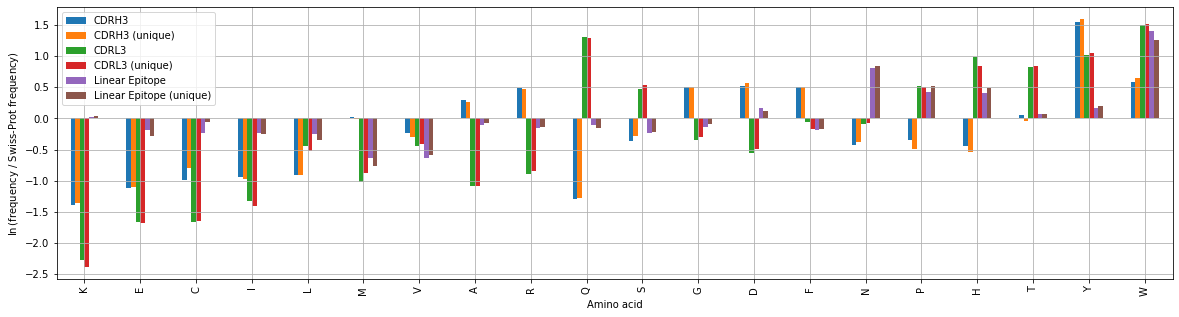

In [29]:
columns_map = {
    'cdrh3': 'CDRH3',
    'cdrh3_unique': 'CDRH3 (unique)',
    'cdrl3':'CDRL3',
    'cdrl3_unique': 'CDRL3 (unique)',
    'epitope': 'Linear Epitope',
    'epitope_unique': 'Linear Epitope (unique)',
}


receptors_unique = receptors.rename(columns={
    'cdrh3': 'cdrh3_unique',
    'cdrl3':'cdrl3_unique',
    'epitope': 'epitope_unique',
})

plot_aa_dist_dbnorm(df_dict={
    'cdrh3': receptors_dup,
    'cdrl3': receptors_dup,
    'epitope': receptors_dup,
    'cdrh3_unique': receptors_unique,
    'cdrl3_unique': receptors_unique,
    'epitope_unique': receptors_unique,
}, columns_map=columns_map, plot_kwargs={'figsize': (20, 5)})

## Epitopes

Similarly to the previous analysis, let us check how is the distribution of all linear and discontinuous epitopes.

To start with, we will need to load the sequences that are linear (independently of being related to a CDR3 chain).

In [30]:
linear_epitope_dup = Normalizer(linear_csv) \
            .columns({
                'Description': 'epitope',
            }) \
            .trim(['epitope']) \
            .filter(column='epitope', pattern=r'^[A-Z]+$') \
            .drop_nan().finish()

linear_epitope_dup = linear_epitope_dup.rename(columns={'epitope': 'LED'})

linear_epitope_dup

,LED
1,IEESDDRRYDLVGP
25,KQHTVTTTTKGE
26,KQHTVTTTTKGE
27,KQHTVTTTTKGE
28,RMKQLEPKVEELLPKNYHLENEVARLKKLVGER
...,...
1814,SNNPDWDF
1815,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANQV
1816,PNPLGFFPD
1817,FGANSNNPDW


To have a better view of the data, we will also include frequency of unique epitopes.

Note that duplicated epitopes may impact on the representativeness of an amino acid.

In [31]:
linear_epitope_unique = Normalizer(linear_epitope_dup).drop_duplicates().finish()

linear_epitope_unique = linear_epitope_unique.rename(columns={'LED': 'LEU'})

linear_epitope_unique

,LEU
1,IEESDDRRYDLVGP
25,KQHTVTTTTKGE
28,RMKQLEPKVEELLPKNYHLENEVARLKKLVGER
29,YHLENEVARLKK
30,WNWFDITNW
...,...
1814,SNNPDWDF
1815,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANQV
1816,PNPLGFFPD
1817,FGANSNNPDW


Let us do the same with discontinguous epitopes. Note here that the regular expression pattern queries for sequences consisting of amino acid residue followed by its position.

In [32]:
disc = load(columns=['Description'])

dis_epitope_dup = Normalizer(disc) \
            .columns({
                'Description': 'epitope',
            }) \
            .trim(['epitope']) \
            .filter(column='epitope', pattern=r'^(?:[A-Z][0-9]+,\s*)*[A-Z][0-9]+$') \
            .drop_nan().finish()

dis_epitope_dup

,epitope
0,"H15, G16, Y20, R21, W63, R73, L75, N77, N93, K..."
1,"F37, G38, K61, E62, E63, A97, K100, K101, N104..."
2,"H33, G34, N37, Y38, R39, W81, R91, L93, T107, ..."
3,"G58, L59, S61, P62, C63, K64, D65, G109, G110,..."
4,"S206, S207, A208, A209, T210, K211, K212, T213..."
...,...
1125357,"E340, V341, N343, T345, R346, F347, A348, Y351..."
1125358,"E340, V341, N343, T345, R346, F347, A348, Y351..."
1125359,"E340, V341, N343, T345, R346, F347, A348, Y351..."
1125360,"Q14, Y144, Y145, H146, K147, M153, F157, R158,..."


In [33]:
def remove_position(seq):
    '''Remove amino acid position from discontinuous epitopes.'''
    res = [aa.strip()[0] for aa in seq.split(',')]
    
    return ''.join(res)

dis_epitope_dup['DED'] = dis_epitope_dup['epitope'].map(remove_position)

assert(len(dis_epitope_dup['DED'].loc[dis_epitope_dup['DED'].str.contains(r'[0-9]')]) == 0)

dis_epitope_dup

,epitope,DED
0,"H15, G16, Y20, R21, W63, R73, L75, N77, N93, K...",HGYRWRLNNKKSD
1,"F37, G38, K61, E62, E63, A97, K100, K101, N104...",FGKEEAKKNE
2,"H33, G34, N37, Y38, R39, W81, R91, L93, T107, ...",HGNYRWRLTNKKSDGN
3,"G58, L59, S61, P62, C63, K64, D65, G109, G110,...",GLSPCKDGGSPWPP
4,"S206, S207, A208, A209, T210, K211, K212, T213...",SSAATKKTAATVNSKKDSNGT
...,...,...
1125357,"E340, V341, N343, T345, R346, F347, A348, Y351...",EVNTRFAYNKLYNRITNGVEF
1125358,"E340, V341, N343, T345, R346, F347, A348, Y351...",EVNTRFAYNKLYNRITNGVEF
1125359,"E340, V341, N343, T345, R346, F347, A348, Y351...",EVNTRFAYNKLYNRITNGVEF
1125360,"Q14, Y144, Y145, H146, K147, M153, F157, R158,...",QYYHKMFRRYLTPGDS


In [34]:
dis_epitope_unique = Normalizer(dis_epitope_dup[['DED']]).drop_duplicates().finish()

dis_epitope_unique = dis_epitope_unique.rename(columns={'DED': 'DEU'})

dis_epitope_unique

,DEU
0,HGYRWRLNNKKSD
1,FGKEEAKKNE
2,HGNYRWRLTNKKSDGN
3,GLSPCKDGGSPWPP
4,SSAATKKTAATVNSKKDSNGT
...,...
570177,KGSN
570187,QKKEHEDDLYNLIPQ
570189,QKHEDLYNLIPQASE
1125327,QYYHKMFRRYLTPGDS


To check how epitopes in general are composed, we will also concatenate discontinuous and linear epitopes before counting amino acid frequencies.

In [35]:
all_epitope_dup = pd.DataFrame({
    'AED': pd.concat([linear_epitope_dup['LED'], dis_epitope_dup['DED']])
})

all_epitope_dup

,AED
1,IEESDDRRYDLVGP
25,KQHTVTTTTKGE
26,KQHTVTTTTKGE
27,KQHTVTTTTKGE
28,RMKQLEPKVEELLPKNYHLENEVARLKKLVGER
...,...
1125357,EVNTRFAYNKLYNRITNGVEF
1125358,EVNTRFAYNKLYNRITNGVEF
1125359,EVNTRFAYNKLYNRITNGVEF
1125360,QYYHKMFRRYLTPGDS


In [36]:
all_epitope_unique = Normalizer(all_epitope_dup).drop_duplicates().finish()

all_epitope_unique = all_epitope_unique.rename(columns={'AED': 'AEU'})

all_epitope_unique

,AEU
1,IEESDDRRYDLVGP
25,KQHTVTTTTKGE
28,RMKQLEPKVEELLPKNYHLENEVARLKKLVGER
29,YHLENEVARLKK
30,WNWFDITNW
...,...
570177,KGSN
570187,QKKEHEDDLYNLIPQ
570189,QKHEDLYNLIPQASE
1125327,QYYHKMFRRYLTPGDS


Finally, we can plot all this information in one bar plot, using the same function we defined previously.

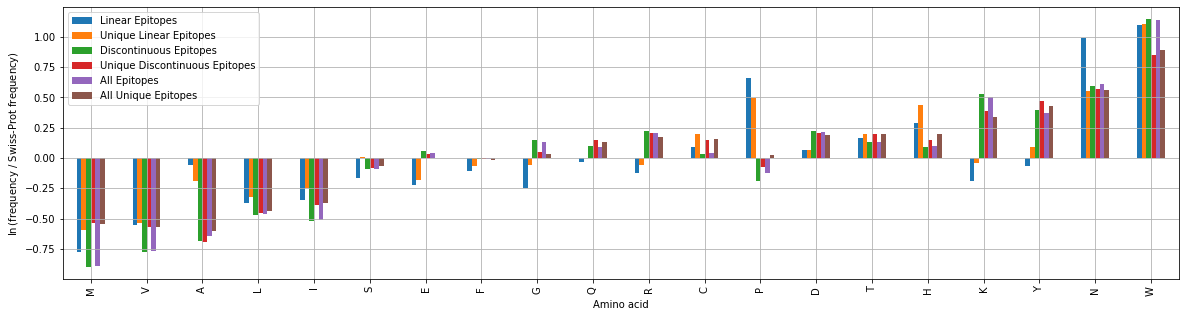

In [37]:
plot_aa_dist_dbnorm(
    df_dict={
        'LED': linear_epitope_dup, 
        'LEU': linear_epitope_unique,
        'DED': dis_epitope_dup,
        'DEU': dis_epitope_unique,
        'AED': all_epitope_dup,
        'AEU': all_epitope_unique,
    },
    columns_map={
        'LED': 'Linear Epitopes',
        'LEU': 'Unique Linear Epitopes',
        'DED': 'Discontinuous Epitopes',
        'DEU': 'Unique Discontinuous Epitopes',
        'AED': 'All Epitopes',
        'AEU': 'All Unique Epitopes',
    },
    plot_kwargs={
        'figsize': (20, 5)
    }
)

## Length distribution

Another characteristic interesting to be checked is the length distribution of these sequences we have been working with.

In [38]:
linear_hist = receptors.reset_index()[['epitope']].copy()

linear_hist['LEU'] = linear_hist['epitope'].map(lambda s: len(s))

linear_hist.describe()

,LEU
count,485.000000
mean,14.024742
std,6.823589
min,3.000000
25%,9.000000
50%,12.000000
75%,18.000000
max,46.000000


In [39]:
cdrl3_hist = receptors[['cdrl3']].copy()

cdrl3_hist['cdrl3'] = cdrl3_hist['cdrl3'].map(lambda s: len(s))

cdrl3_hist.describe()

,cdrl3
count,485.000000
mean,9.150515
std,1.206056
min,4.000000
25%,9.000000
50%,9.000000
75%,9.000000
max,14.000000


In [40]:
cdrh3_hist = receptors[['cdrh3']].copy()

cdrh3_hist['cdrh3'] = cdrh3_hist['cdrh3'].map(lambda s: len(s))

cdrh3_hist.describe()

,cdrh3
count,485.000000
mean,13.882474
std,4.832804
min,2.000000
25%,11.000000
50%,13.000000
75%,17.000000
max,27.000000


Plotting this information as a histogram, we get the following result.

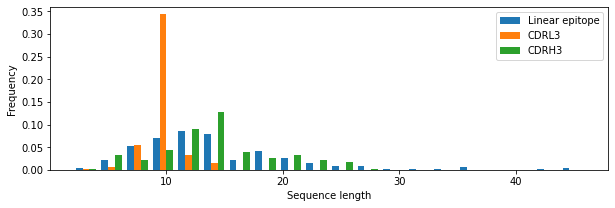

In [41]:
hist = [linear_hist['LEU'], cdrl3_hist['cdrl3'], cdrh3_hist['cdrh3']]

plt.figure(figsize=(10, 3))
plt.hist(hist, bins=20, label=['Linear epitope', 'CDRL3', 'CDRH3'], density=True)

plt.legend(loc='upper right')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.show()

This concludes our exploratory analysis of the IEDB dataset, specifically its subset of linear epitopes with associated complementarity-determining regions.

If you find any mistakes or have any question regarding this material or its corresponding paper, feel free to get in touch with us.

Henrique F. Simões <[henrique.simoes@students.ic.unicamp.br](mailto:henrique.simoes@students.ic.unicamp.br)><br>
Undergraduate Student in Computer Science<br>
Institute of Computing (IC) <br>
University of Campinas (Unicamp) -- São Paulo -- Brazil